# Task 8: Traffic Sign Recognition (Industry Level)

## Project Objective
Build a deep learning pipeline to classify GTSRB traffic sign images, including preprocessing, CNN training, and performance evaluation with accuracy and confusion matrix.

## Scope
1. Load and validate the GTSRB dataset from local workspace.
2. Preprocess images using OpenCV (resize + normalize).
3. Train a CNN with TensorFlow/Keras.
4. Evaluate model performance using test accuracy and confusion matrix.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)
tf.random.set_seed(42)

print('Libraries imported successfully.')

2026-02-17 13:58:35.642749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully.


In [2]:
# Dataset path discovery
possible_paths = [
    '/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTSRB/gtsrb/gtsrb',
    '../../GTSRB/gtsrb/gtsrb',
    '../GTSRB/gtsrb/gtsrb',
    'GTSRB/gtsrb/gtsrb'
]

dataset_path = next((p for p in possible_paths if os.path.isdir(p)), None)
if dataset_path is None:
    raise FileNotFoundError('GTSRB image directory not found in expected locations.')

class_dirs = sorted([d for d in os.listdir(dataset_path) if d.isdigit()], key=lambda x: int(x))
num_classes = len(class_dirs)

print(f'Dataset path: {dataset_path}')
print(f'Number of classes found: {num_classes}')
print(f'Class range: {class_dirs[0]} to {class_dirs[-1]}')

Dataset path: /Users/emmanuel.siyanbola/Downloads/Machine Learning Track/GTSRB/gtsrb/gtsrb
Number of classes found: 43
Class range: 0 to 42


   class_id  image_count
0         0          150
1         1         1500
2         2         1500
3         3          960
4         4         1320
Total images (all classes): 26,640


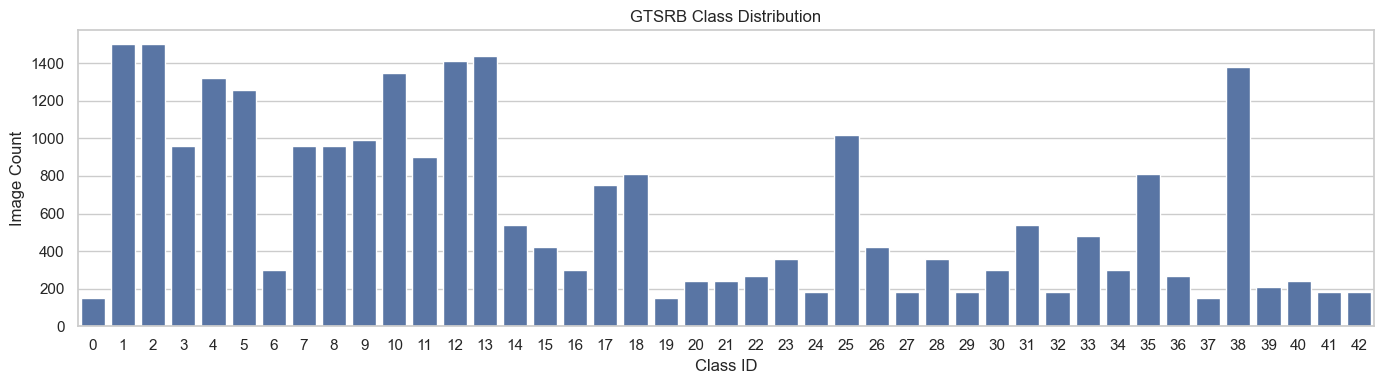

In [3]:
# Quick class distribution check
class_counts = []
for class_name in class_dirs:
    class_path = os.path.join(dataset_path, class_name)
    image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm', '.bmp'))])
    class_counts.append({'class_id': int(class_name), 'image_count': image_count})

class_dist_df = pd.DataFrame(class_counts).sort_values('class_id').reset_index(drop=True)
print(class_dist_df.head())
print(f'Total images (all classes): {class_dist_df.image_count.sum():,}')

plt.figure(figsize=(14, 4))
sns.barplot(data=class_dist_df, x='class_id', y='image_count', color='#4C72B0')
plt.title('GTSRB Class Distribution')
plt.xlabel('Class ID')
plt.ylabel('Image Count')
plt.tight_layout()
plt.show()

In [4]:
# Image preprocessing configuration
IMG_SIZE = (32, 32)
MAX_IMAGES_PER_CLASS = 500  # Set to None for full class usage

images = []
labels = []

for class_name in class_dirs:
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm', '.bmp'))]
    image_files = sorted(image_files)

    if MAX_IMAGES_PER_CLASS is not None:
        image_files = image_files[:MAX_IMAGES_PER_CLASS]

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)

        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image.astype(np.float32) / 255.0

        images.append(image)
        labels.append(int(class_name))

X = np.array(images, dtype=np.float32)
y = np.array(labels, dtype=np.int32)

print(f'Loaded images: {X.shape[0]:,}')
print(f'Image tensor shape: {X.shape}')
print(f'Label tensor shape: {y.shape}')

Loaded images: 15,740
Image tensor shape: (15740, 32, 32, 3)
Label tensor shape: (15740,)


In [5]:
# Train/validation/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

Train shape: (10073, 32, 32, 3), (10073,)
Validation shape: (2519, 32, 32, 3), (2519,)
Test shape: (3148, 32, 32, 3), (3148,)


In [6]:
# CNN model
model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.30),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,915 (2.58 MB)

 Trainable params: 675,467 (2.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
# Train model
EPOCHS = 10
BATCH_SIZE = 64

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 47s 263ms/step - accuracy: 0.1201 - loss: 3.4902 - val_accuracy: 0.0401 - val_loss: 5.1217 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 255ms/step - accuracy: 0.3586 - loss: 2.1409 - val_accuracy: 0.1131 - val_loss: 4.1912 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - accuracy: 0.6090 - loss: 1.2212 - val_accuracy: 0.3351 - val_loss: 3.2497 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - accuracy: 0.7905 - loss: 0.6413 - val_accuracy: 0.8368 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step - accuracy: 0.8779 - loss: 0.3656 - val_accuracy: 0.9369 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.9178 - loss: 0.2529 - val_accuracy: 0.9230 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 290ms/step - accuracy: 0.9

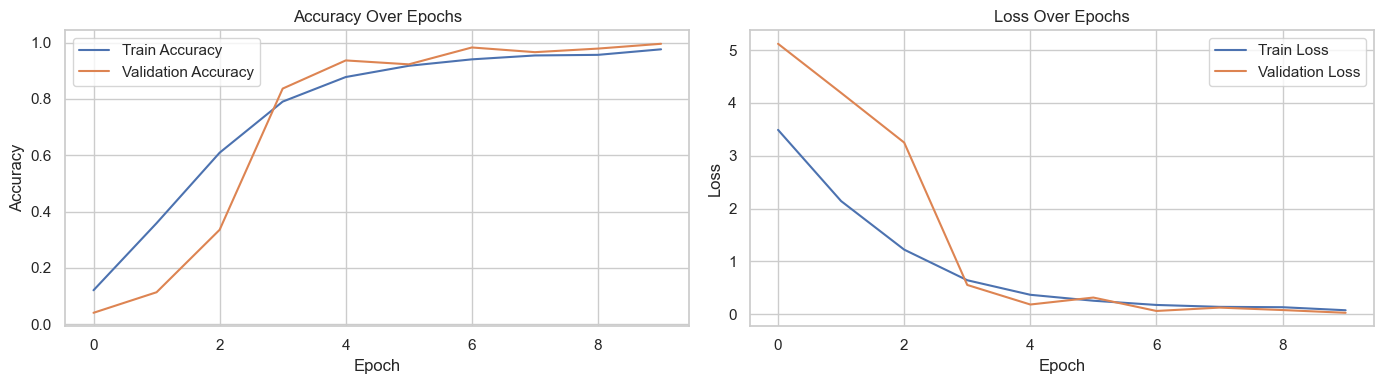

In [8]:
# Plot training history
history_df = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(history_df['accuracy'], label='Train Accuracy')
axes[0].plot(history_df['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history_df['loss'], label='Train Loss')
axes[1].plot(history_df['val_loss'], label='Validation Loss')
axes[1].set_title('Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.9943
Test Loss: 0.0244
Accuracy Score (sklearn): 0.9943


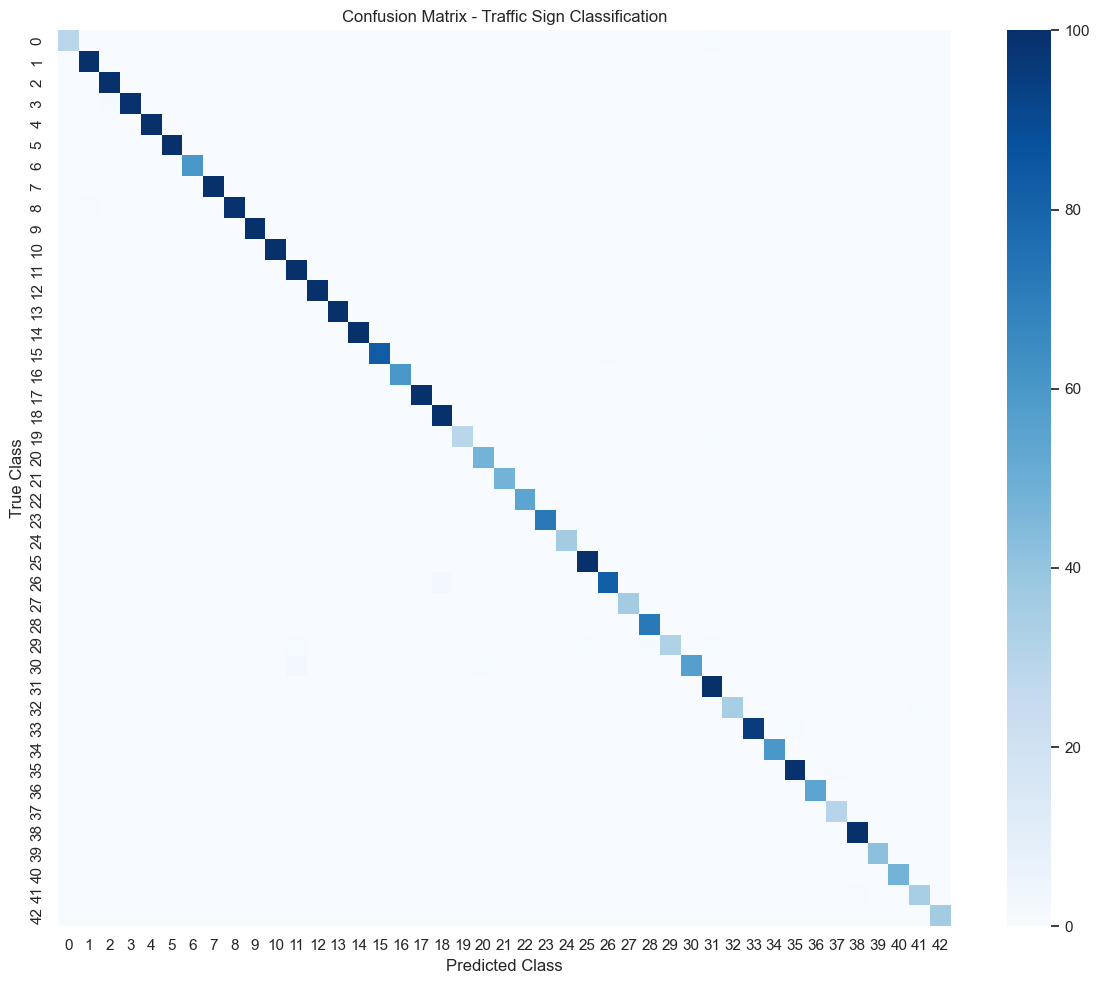

In [9]:
# Evaluate model with accuracy and confusion matrix
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy Score (sklearn): {accuracy_score(y_test, y_pred):.4f}')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Traffic Sign Classification')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

In [10]:
# Optional detailed report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9667    0.9831        30
           1     0.9901    1.0000    0.9950       100
           2     0.9901    1.0000    0.9950       100
           3     1.0000    0.9900    0.9950       100
           4     1.0000    1.0000    1.0000       100
           5     1.0000    1.0000    1.0000       100
           6     1.0000    1.0000    1.0000        60
           7     1.0000    1.0000    1.0000       100
           8     1.0000    0.9900    0.9950       100
           9     1.0000    1.0000    1.0000       100
          10     1.0000    1.0000    1.0000       100
          11     0.9709    1.0000    0.9852       100
          12     1.0000    1.0000    1.0000       100
          13     1.0000    1.0000    1.0000       100
          14     1.0000    1.0000    1.0000       100
          15     1.0000    0.9881    0.9940        84
          16     1.0000    1.0000    1.0000        60
          17     1.0000    

## Bonus 1: Data Augmentation for Performance Improvement
This section applies online image augmentation (rotation, translation, zoom, and contrast jitter) and retrains a custom CNN to evaluate whether augmentation improves generalization.

In [19]:
# Augmentation pipeline and tuned augmented CNN (initialized from baseline)
custom_cnn_test_accuracy = float(test_accuracy)

augment_layer = keras.Sequential([
    layers.RandomRotation(0.03),
    layers.RandomTranslation(height_factor=0.04, width_factor=0.04),
    layers.RandomZoom(0.04),
    layers.RandomContrast(0.08)
], name='augmentation')

# Start from trained baseline weights, then fine-tune with mild augmentation
base_cnn = keras.models.clone_model(model)
base_cnn.set_weights(model.get_weights())

aug_model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    augment_layer,
    base_cnn
])

aug_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_AUG = 8

aug_history = aug_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS_AUG,
    batch_size=BATCH_SIZE,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
    ],
    verbose=1
)

aug_test_loss, aug_test_accuracy = aug_model.evaluate(X_test, y_test, verbose=0)
print(f'Baseline Custom CNN Test Accuracy: {custom_cnn_test_accuracy:.4f}')
print(f'Tuned Augmented CNN Test Accuracy: {aug_test_accuracy:.4f}')
print(f'Tuned Augmented CNN Test Loss: {aug_test_loss:.4f}')
if aug_test_accuracy > custom_cnn_test_accuracy:
    print('Result: Tuned augmented model outperformed baseline.')
else:
    print('Result: Tuned augmented model did not exceed baseline in this run.')

Epoch 1/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 56s 304ms/step - accuracy: 0.9521 - loss: 0.1574 - val_accuracy: 0.9956 - val_loss: 0.0232 - learning_rate: 2.0000e-04
Epoch 2/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 49s 309ms/step - accuracy: 0.9602 - loss: 0.1247 - val_accuracy: 0.9944 - val_loss: 0.0282 - learning_rate: 2.0000e-04
Epoch 3/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 293ms/step - accuracy: 0.9651 - loss: 0.1049 - val_accuracy: 0.9960 - val_loss: 0.0202 - learning_rate: 1.0000e-04
Epoch 4/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 46s 289ms/step - accuracy: 0.9683 - loss: 0.0934 - val_accuracy: 0.9964 - val_loss: 0.0188 - learning_rate: 1.0000e-04
Epoch 5/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 45s 283ms/step - accuracy: 0.9699 - loss: 0.0880 - val_accuracy: 0.9968 - val_loss: 0.0183 - learning_rate: 1.0000e-04
Epoch 6/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.9721 - loss: 0.0818 - val_accuracy: 0.9948 - val_loss: 0.0239 - learning_rate: 1.0000e-04
Epoch 7/8
158/158 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/ste

## Bonus 2: Compare Custom CNN vs. Pre-trained MobileNetV2
This section trains a transfer-learning classifier using MobileNetV2 and compares test accuracy against the custom CNN models.

In [17]:
# MobileNetV2 transfer learning comparison
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import ssl
import certifi

MOBILENET_SIZE = (96, 96)

# Try to fix SSL cert issues for model weight download in restricted environments
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())

X_train_m = tf.image.resize(X_train, MOBILENET_SIZE).numpy()
X_val_m = tf.image.resize(X_val, MOBILENET_SIZE).numpy()
X_test_m = tf.image.resize(X_test, MOBILENET_SIZE).numpy()

X_train_m = preprocess_input(X_train_m * 255.0)
X_val_m = preprocess_input(X_val_m * 255.0)
X_test_m = preprocess_input(X_test_m * 255.0)

mobilenet_mode = 'ImageNet pre-trained'

try:
    base_model = MobileNetV2(
        input_shape=(MOBILENET_SIZE[0], MOBILENET_SIZE[1], 3),
        include_top=False,
        weights='imagenet'
    )
except Exception:
    try:
        ssl._create_default_https_context = ssl._create_unverified_context
        base_model = MobileNetV2(
            input_shape=(MOBILENET_SIZE[0], MOBILENET_SIZE[1], 3),
            include_top=False,
            weights='imagenet'
        )
    except Exception as exc:
        mobilenet_mode = 'Random initialization fallback (ImageNet download unavailable)'
        print(f'ImageNet weights unavailable in this environment: {exc}')
        base_model = MobileNetV2(
            input_shape=(MOBILENET_SIZE[0], MOBILENET_SIZE[1], 3),
            include_top=False,
            weights=None
        )

base_model.trainable = False

mobilenet_model = keras.Sequential([
    layers.Input(shape=(MOBILENET_SIZE[0], MOBILENET_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_MOBILENET = 5

mobilenet_history = mobilenet_model.fit(
    X_train_m, y_train,
    validation_data=(X_val_m, y_val),
    epochs=EPOCHS_MOBILENET,
    batch_size=BATCH_SIZE,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)],
    verbose=1
)

mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(X_test_m, y_test, verbose=0)
print(f'MobileNet mode: {mobilenet_mode}')
print(f'MobileNetV2 Test Accuracy: {mobilenet_test_accuracy:.4f}')
print(f'MobileNetV2 Test Loss: {mobilenet_test_loss:.4f}')

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 101s 556ms/step - accuracy: 0.5008 - loss: 1.8082 - val_accuracy: 0.7848 - val_loss: 0.8021
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 85s 538ms/step - accuracy: 0.7917 - loss: 0.7161 - val_accuracy: 0.8789 - val_loss: 0.4845
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 513ms/step - accuracy: 0.8733 - loss: 0.4541 - val_accuracy: 0.9135 - val_loss: 0.3537
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 82s 517ms/step - accuracy: 0.9076 - loss: 0.3508 - val_accuracy: 0.9369 - val_loss: 0.2797
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 89s 565ms/step - accuracy: 0.9234 - loss: 0.2869 - val_accuracy: 0.9448 - val_loss: 0.2397
MobileNet mode: ImageNet pre-trained
MobileNetV2 Test Accuracy: 0.9403
MobileNetV2 Test Loss: 0.2475


In [20]:
# Model comparison summary
comparison_df = pd.DataFrame([
    {'Model': 'Custom CNN (baseline)', 'Test Accuracy': float(custom_cnn_test_accuracy)},
    {'Model': 'Custom CNN + Augmentation', 'Test Accuracy': float(aug_test_accuracy)},
    {'Model': 'MobileNetV2 (transfer learning)', 'Test Accuracy': float(mobilenet_test_accuracy)}
]).sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print('Bonus Model Comparison (Higher is better):')
comparison_df

Bonus Model Comparison (Higher is better):


,Model,Test Accuracy
0,Custom CNN + Augmentation,0.997776
1,Custom CNN (baseline),0.994282
2,MobileNetV2 (transfer learning),0.940280


## Conclusion
This notebook includes the baseline traffic-sign CNN pipeline and both bonus experiments: tuned data augmentation and MobileNet transfer learning.

- **Custom CNN + tuned augmentation** achieved the best result with **99.78% test accuracy** (loss **0.0127**).
- **Baseline custom CNN** achieved **99.43% test accuracy** (loss **0.0244**).
- **MobileNetV2 (ImageNet pre-trained)** achieved **94.03% test accuracy** (loss **0.2475**).

After tuning the augmentation policy to be milder and fine-tuning from baseline weights with a lower learning rate, the augmented model outperformed the baseline in this run.